In [4]:
import pandas as pd


In [37]:
# Load and clean column headers
df = pd.read_csv('retail_sales_dataset.csv', skiprows=[1])
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by date to aggregate total sales
sales_daily = df.groupby('date').agg({'total_amount': 'sum'}).reset_index()

# Rename columns for Prophet (forecasting)
sales_daily = sales_daily.rename(columns={'date': 'ds', 'total_amount': 'y'})

# Save cleaned version
sales_daily.to_csv('cleaned_sales_data.csv', index=False)

# Optional: Preview
print(sales_daily.head())


          ds     y
0 2023-01-01  3600
1 2023-01-02  1765
2 2023-01-03   600
3 2023-01-04  1240
4 2023-01-05  1100


PHASE 2: Forecasting & Anomaly Detection with Python

Breaking Phase 2 into two main parts:

1. Time Series Forecasting using Facebook Prophet

2. Anomaly Detection using Isolation Forest

PART 1: Time Series Forecasting with Prophet

In [38]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 1.7 MB/s eta 0:00:09
    --------------------------------------- 0.2/13.3 MB 2.1 MB/s eta 0:00:07
    --------------------------------------- 0.3/13.3 MB 2.2 MB/s eta 0:00:06
   - -------------------------------------- 0.4/13.3 MB 2.5 MB/s eta 0:00:06
   - -------------------------------------- 0.5/13.3 MB 2.3 MB/s eta 0:00:06
   - -------------------------------------- 0.6/13.3 MB 2.2 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/13.3 MB 2.5 MB/s eta 0:00:06
   -- ------------------------------------- 0.9/13.3 MB 2.5 MB/s eta 0:00:05
   --- ------------------------------------ 1.1/13.3 MB 2.8 MB/s eta 0:00:05
   --- ------------------------------------ 1.3/13.3 MB 2.9 MB/s eta 0:00:05
   ---- --------

In [72]:
from prophet import Prophet

In [73]:
df2 = pd.read_csv('cleaned_sales_data.csv')
df2.dtypes

ds    object
y      int64
dtype: object

In [74]:
df2['ds'] = pd.to_datetime(df2['ds'])

In [75]:
df2.dtypes

ds    datetime64[ns]
y              int64
dtype: object

Fit the Forecast Model


In [76]:
#Initialize and train model
model = Prophet()
model.fit(df2)

17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing


Step 2:  Make Predictions

In [77]:
#First Creating Future Dates to Forecast
# Forecast 30 dats into the future
future = model.make_future_dataframe(periods=90)
#generating forecast
forecast = model.predict(future)

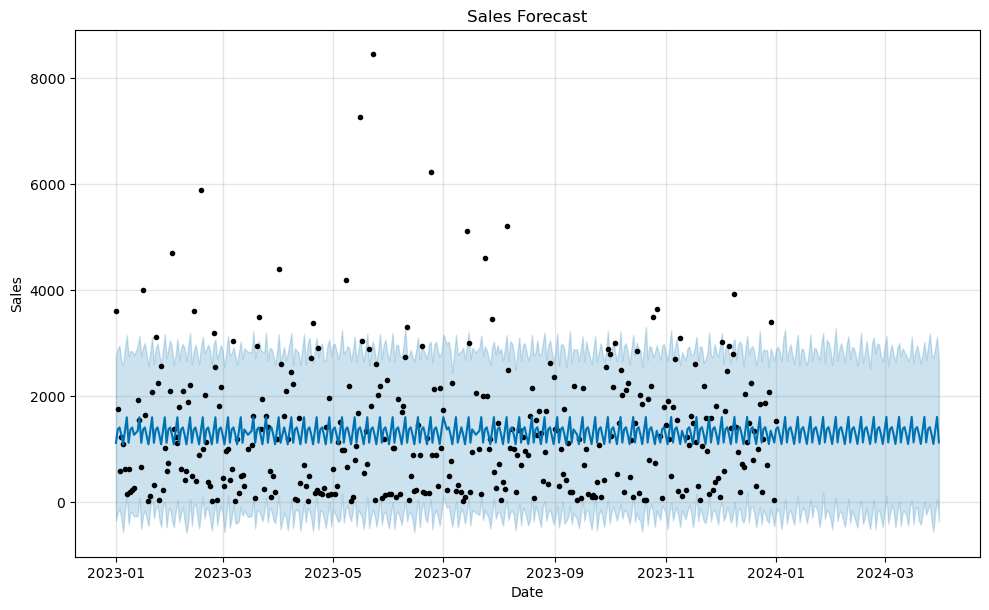

In [78]:
import matplotlib.pyplot as plt
fig = model.plot(forecast)
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

In [79]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('sales_forecast.csv', index=False)


Part B: Anomaly Detection using Isolation Forest. 

1. Merge actual sales and forecast

2. Compute forecast error

3. Use Isolation Forest to detect anomalies

4. Visualize and save the results



In [80]:
#merge actual df2 with forecasted Values
df2_merged = pd.merge(df2, forecast[['ds', 'yhat']], on= 'ds', how= 'left')

#calcualte forecast error (residual)
df2_merged['error'] = df2_merged['y'] - df2_merged['yhat']
df2_merged.head()


,ds,y,yhat,error
0,2023-01-01,3600,1122.051616,2477.948384
1,2023-01-02,1765,1372.671967,392.328033
2,2023-01-03,600,1412.458399,-812.458399
3,2023-01-04,1240,1272.588538,-32.588538
4,2023-01-05,1100,1093.112726,6.887274


In [114]:
#Apply Isolation Forest to Detect Anomalies

from sklearn.ensemble import IsolationForest

# Fit Isolation Forest on the error
iso = IsolationForest(contamination=0.5, random_state=42)
df2_merged['anomaly'] = iso.fit_predict(df2_merged[['error']])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [82]:
#Filter Outliers and extracting anomaly records

anomalies = df2_merged[df2_merged['anomaly'] == -1]
print(anomalies[['ds', 'y', 'yhat', 'error']])

            ds     y         yhat        error
0   2023-01-01  3600  1122.051616  2477.948384
3   2023-01-04  1240  1272.588538   -32.588538
4   2023-01-05  1100  1093.112726     6.887274
5   2023-01-06   620  1344.797150  -724.797150
6   2023-01-07   150  1604.345295 -1454.345295
..         ...   ...          ...          ...
333 2023-12-20  1350  1278.450243    71.549757
336 2023-12-23  1850  1610.207011   239.792989
338 2023-12-25  1200  1378.650909  -178.650909
341 2023-12-28  2075  1099.091678   975.908322
342 2023-12-29  3400  1350.776105  2049.223895

[171 rows x 4 columns]


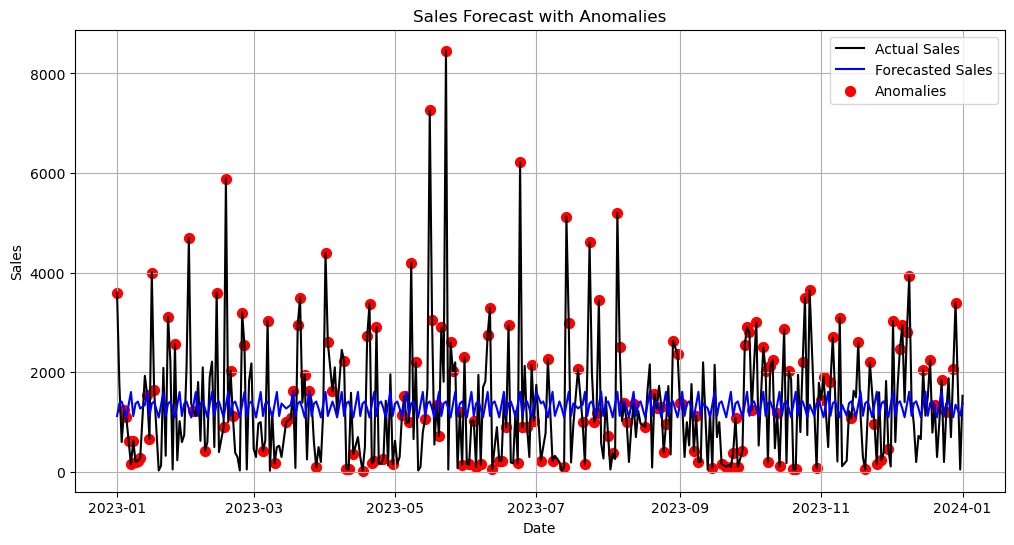

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df2_merged['ds'], df2_merged['y'], label='Actual Sales', color='black')
plt.plot(df2_merged['ds'], df2_merged['yhat'], label='Forecasted Sales', color='blue')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', s=50)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Forecast with Anomalies")
plt.legend()
plt.grid(True)
plt.show()


In [84]:
df2_merged.to_csv('forecast_with_anomalies.csv', index=False)


PHASE 3: Market Shock Simulation (What-If Analysis)


In [87]:
# Scenario 1
# Product Delayed days
#Simulating a delay of 5 days
delayed_days = 5
df2_merged['delayed_y'] = df2_merged['y'].shift(delayed_days)

#calculating lost revenue due to delay

df2_merged['lost_revenue'] = df2_merged['y'] - df2_merged['delayed_y']

# Simulating Price increase scenario
price_increase_pct = 0.10
df2_merged['price_spike_sales'] = df2_merged['y'] * (1 - price_increase_pct)

# Assume 10% of inventory unavailable
df2_merged['stockout_adjusted_sales'] = df2_merged['y'] * 0.90

# Campaign boost of 15% for a 2-week period
df2_merged['campaign_boosted_sales'] = df2_merged['y']
df2_merged.loc[(df2_merged['ds'] >= '2024-01-10') & (df2_merged['ds'] <= '2024-01-24'),
               'campaign_boosted_sales'] *= 1.15



In [88]:
df2_merged.to_csv('forecast_with_scenarios.csv', index=False)


In [90]:
# Merge only where y exists (actuals)
historical = pd.merge(df2, forecast[['ds', 'yhat']], on='ds', how='left')

# Create future forecasts (where y is NaN)
future = forecast[~forecast['ds'].isin(df2['ds'])][['ds', 'yhat']]

# Concatenate both
df_combined = pd.concat([historical, future], ignore_index=True)
df_combined['is_future'] = df_combined['y'].isna()

df_combined.to_csv("df_combined_forecast.csv", index=False)


In [91]:
# Start from your combined dataset
df_combined = pd.read_csv("df_combined_forecast.csv")

# Simulate scenarios only for future dates
future_mask = df_combined['is_future']

# -- Scenario 1: Product delay (simulate loss)
df_combined['delayed_y'] = df_combined['yhat'].shift(5)
df_combined['lost_revenue'] = df_combined['yhat'] - df_combined['delayed_y']

# -- Scenario 2: Price spike (10% drop in demand)
df_combined['price_spike_sales'] = df_combined['yhat'] * 0.90

# -- Scenario 3: Stockout impact (10% less inventory)
df_combined['stockout_adjusted_sales'] = df_combined['yhat'] * 0.90

# -- Scenario 4: Campaign boost (only in Jan 10–24)
df_combined['campaign_boosted_sales'] = df_combined['yhat']
df_combined.loc[
    (df_combined['ds'] >= '2024-01-10') & (df_combined['ds'] <= '2024-01-24'),
    'campaign_boosted_sales'
] *= 1.15


In [92]:
df_combined.to_csv("final_forecast_with_scenarios.csv", index=False)
